In [1]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-11-20 16:56:46.770052: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [4]:
import tensorflow as tf

# import keras 
from tensorflow.keras.models import Sequential # intitialize the ANN
from tensorflow.keras.layers import Dense, Activation, Dropout 

In [5]:
import source.plots as plots

In [6]:
RSEED = 42
np.random.seed(seed=RSEED)
tf.random.set_seed(RSEED)

In [8]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/features_60_dur2_all.npy')
data.shape

(21390, 30, 63)

In [7]:
data = np.load('data/features_wave_all.npy')

In [9]:
import numpy as np

def split_data(data, train_size=0.8, random_state=None):
    np.random.seed(seed=RSEED)

    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(train_size * len(unique_epoch_ids)))
    print(f'{train_samples_nr} of epochs for training, {len(unique_epoch_ids) - train_samples_nr} of epochs for testing/validation')

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [10]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape, f'ratio of seizures {y_train.sum()/len(y_train):.2f}')
print(f'test shape {X_test.shape}, ratio of seizures {y_test.sum()/len(y_test):.2f}')

552 of epochs for training, 138 of epochs for testing/validation
train shape (17112, 30, 92) ratio of seizures 0.25
test shape (4278, 30, 92), ratio of seizures 0.25


In [11]:
# Scaling features
num_features_train = X_train[:,:,2:]
num_features_test = X_test[:,:,2:]

# Get the dimensions of the original array
num_epochs_tr, num_segments_per_epoch_tr, features_tr = num_features_train.shape
num_epochs_te, num_segments_per_epoch_te, features_te = num_features_test.shape

# Reshape the array to 2D
reshaped_array_train = num_features_train.reshape(num_epochs_tr * num_segments_per_epoch_tr, features_tr)
reshaped_array_test = num_features_test.reshape(num_epochs_te * num_segments_per_epoch_te, features_te)

# Scaling features
scaler = StandardScaler()
num_features_scaled_tr = scaler.fit_transform(reshaped_array_train)
num_features_scaled_te = scaler.transform(reshaped_array_test)

X_train_scaled = num_features_scaled_tr.reshape(num_epochs_tr, num_segments_per_epoch_tr, features_tr)
X_test_scaled = num_features_scaled_te.reshape(num_epochs_te, num_segments_per_epoch_te, features_te)

print(f'train shape', X_train_scaled.shape)
print(f'test shape', X_test_scaled.shape)

train shape (17112, 30, 90)
test shape (4278, 30, 90)


In [12]:
X_train = X_train_scaled
X_test = X_test_scaled

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [15]:
class_weight_dict

{0.0: 0.6699029126213593, 1.0: 1.9714285714285715}

In [17]:
N_TRAIN = len(X_train)
EPOCHS = 200
BATCH_SIZE = 1000
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [16]:
STEPS_PER_EPOCH

1

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(512, return_sequences=False, kernel_regularizer=regularizers.l2(0.05)))
model.add(Dropout(0.5))  # Add dropout after LSTM


# Fully connected layer
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.05)))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
#learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001,
    
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.001,
    staircase=False)


optimizer = Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1024)              4444160   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                      

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

# Create ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Combine the callbacks in a list
callbacks = [early_stopping, model_checkpoint]

In [20]:
y_train.shape

(17112,)

In [20]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=BATCH_SIZE, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=EPOCHS,
                    validation_data = (X_test, y_test),
                    # validation_split= 0.2,
                    callbacks=callbacks,
                    )

Epoch 1/200
18/18 [==============================] - 38s 2s/step - loss: 34.9675 - accuracy: 0.4504 - auc: 0.4846 - val_loss: 34.7440 - val_accuracy: 0.2553 - val_auc: 0.4133
Epoch 2/200


/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 36s 2s/step - loss: 34.6945 - accuracy: 0.4632 - auc: 0.5036 - val_loss: 34.4923 - val_accuracy: 0.2550 - val_auc: 0.4583
Epoch 3/200
18/18 [==============================] - 33s 2s/step - loss: 34.4283 - accuracy: 0.4740 - auc: 0.5236 - val_loss: 34.2457 - val_accuracy: 0.2564 - val_auc: 0.4836
Epoch 4/200
18/18 [==============================] - 29s 2s/step - loss: 34.1746 - accuracy: 0.4813 - auc: 0.5371 - val_loss: 34.0020 - val_accuracy: 0.2630 - val_auc: 0.4991
Epoch 5/200
18/18 [==============================] - 30s 2s/step - loss: 33.9350 - accuracy: 0.4866 - auc: 0.5405 - val_loss: 33.7604 - val_accuracy: 0.2838 - val_auc: 0.5211
Epoch 6/200
18/18 [==============================] - 31s 2s/step - loss: 33.6925 - accuracy: 0.4851 - auc: 0.5464 - val_loss: 33.5207 - val_accuracy: 0.2899 - val_auc: 0.5361
Epoch 7/200
18/18 [==============================] - 34s 2s/step - loss: 33.4444 - accuracy: 0.4940 - auc: 0.5610 - val_loss: 33.2826 - v

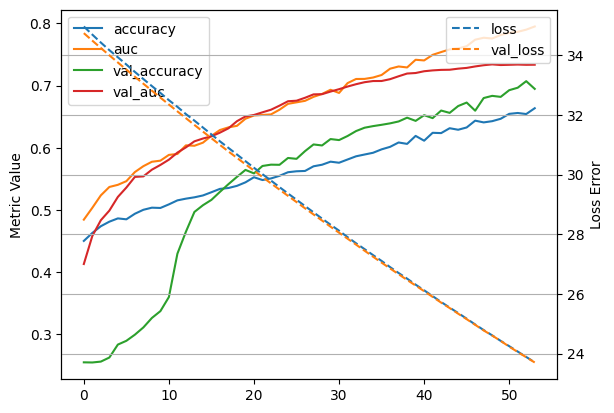

In [21]:
plots.plot_history_metrics(history)

In [22]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {metrics}')

134/134 - 4s - loss: 24.6068 - accuracy: 0.6835 - auc: 0.7341 - 4s/epoch - 30ms/step
Model accuracy: [24.60676383972168, 0.6834969520568848, 0.7340831756591797]


In [ ]:
model.summary()

In [ ]:
y_pred_train = model.predict(X_train)

535/535 [==============================] - 3s 6ms/step


In [24]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

134/134 [==============================] - 5s 33ms/step


(4278, 1)

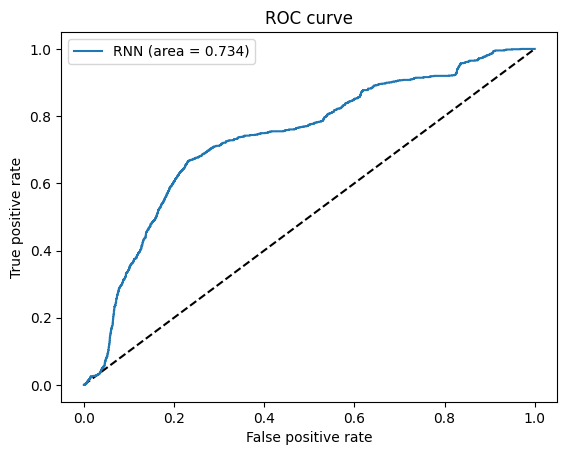

In [25]:
plots.plot_roc(y_test, y_pred)

In [ ]:
metrics

[8.797004699707031, 0.6443302631378174]

In [26]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

metrics = model.evaluate(X_test, y_test)

limit_index = lambda x, arr: min(x,len(arr))
print('Loss:', metrics[limit_index(0,metrics)])
print('AUC:', metrics[limit_index(1,metrics)])
print('Accuracy:', metrics[limit_index(2,metrics)])
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()


134/134 [==============================] - 5s 35ms/step - loss: 24.6068 - accuracy: 0.6835 - auc: 0.7341
Loss: 24.60676383972168
AUC: 0.6834969520568848
Accuracy: 0.7340831756591797
Precision: 0.4273365748244192
Recall: 0.7290322580645161


(1085.0, 1851)

In [ ]:
# Print the results
print("Metrics: ", model.metrics_names)
print("Results: ", metrics)

Metrics:  ['loss', 'accuracy', 'auc']
Results:  [1.255138635635376, 0.7843210697174072, 0.6853933930397034]


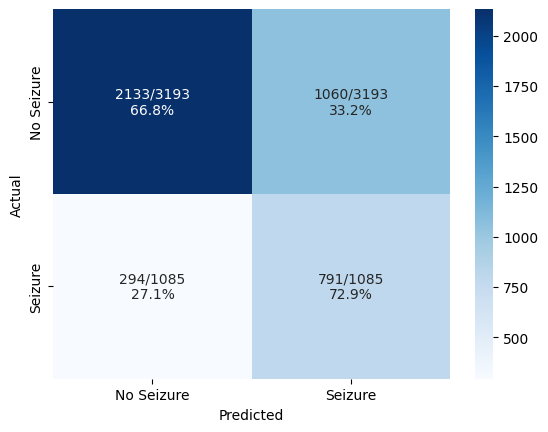

In [27]:
plots.plot_confusion_matrix(y_test, y_pred_c)

In [28]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.67      0.76      3193
         1.0       0.43      0.73      0.54      1085

    accuracy                           0.68      4278
   macro avg       0.65      0.70      0.65      4278
weighted avg       0.76      0.68      0.70      4278



In [ ]:
model_checkpoint.best

1.5083032846450806

In [ ]:
# !mkdir -p saved_model

model.save('saved_model/wavelet_model')

INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit/assets


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit/assets


In [ ]:
# # Define a sequential model
# model = keras.Sequential()

# #model.add(normalizer)

# # Add an input layer with an input shape of (time_steps, input_features)
# model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# # Add a SimpleRNN layer with 32 units (neurons)
# model.add(layers.SimpleRNN(72, activation='tanh'))

# model.add(BatchNormalization())

# # Add the output layer with 1 neuron and sigmoid activation for binary classification
# model.add(layers.Dense(1, activation='sigmoid'))

# # Compile the model with binary cross-entropy loss for binary classification
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# history = model.fit(X_train,  y_train, 
#                     batch_size=100, 
#                     class_weight=class_weight_dict,
#                     shuffle=True,
#                     epochs=300,
#                     validation_data=(X_val, y_val))

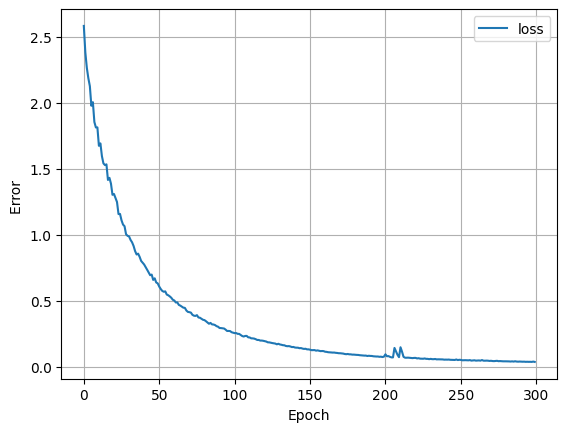

In [ ]:
# plot_loss(history)

In [ ]:
# y_pred = model.predict(X_test).flatten()
# y_pred

16/16 [==============================] - 0s 2ms/step


array([0.6652413 , 0.569696  , 0.6270943 , 0.6571634 , 0.6279296 ,
       0.661146  , 0.6190019 , 0.6956031 , 0.60217565, 0.6422262 ,
       0.6130368 , 0.61739904, 0.5836438 , 0.60966194, 0.61492014,
       0.68353057, 0.62516934, 0.6223092 , 0.60138613, 0.86089545,
       0.5997883 , 0.7082959 , 0.61577535, 0.65439284, 0.6153179 ,
       0.61165124, 0.6138298 , 0.6019997 , 0.69033056, 0.5684809 ,
       0.60205024, 0.6596652 , 0.5667143 , 0.5973395 , 0.5799074 ,
       0.5978519 , 0.69248086, 0.6828316 , 0.5917969 , 0.65039593,
       0.6280549 , 0.5896513 , 0.5801114 , 0.6888158 , 0.6263854 ,
       0.5939749 , 0.6077289 , 0.7062058 , 0.5900531 , 0.61288965,
       0.6144817 , 0.6018636 , 0.6108944 , 0.6096263 , 0.6149801 ,
       0.60750127, 0.654709  , 0.6353007 , 0.60026884, 0.6303653 ,
       0.6049201 , 0.61497486, 0.57438624, 0.5701094 , 0.5770952 ,
       0.5821288 , 0.643623  , 0.621211  , 0.44605097, 0.6186412 ,
       0.5902251 , 0.7171862 , 0.6248064 , 0.6361713 , 0.63841

In [ ]:
# loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 0.6718 - accuracy: 0.5746 - 234ms/epoch - 15ms/step
Model accuracy: 0.5745967626571655


In [ ]:
# from sklearn.metrics import precision_score, recall_score
# y_pred_c = y_pred.round().astype(int)
# precision = precision_score(y_test, y_pred_c)
# recall = recall_score(y_test, y_pred_c)

# loss, accuracy = model.evaluate(X_test, y_test)

# print('Loss:', loss)
# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# y_test.sum(), y_pred_c.sum()

16/16 [==============================] - 0s 2ms/step - loss: 0.6718 - accuracy: 0.5746
Loss: 0.6718045473098755
Accuracy: 0.5745967626571655
Precision: 0.005494505494505495
Recall: 0.03225806451612903


(31.0, 182)